<a href="https://colab.research.google.com/github/nyp-sit/aiup/blob/main/day1-pm/video-anomaly-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://www.nyp.edu.sg/content/dam/nypcorp/sg/en/common/logo-nyp.svg" width="238" height="70"/>

Welcome to the lab! Before we get started here are a few pointers on Jupyter notebooks.

1. The notebook is composed of cells; cells can contain code which you can run, or they can hold text and/or images which are there for you to read.

2. You can execute code cells by clicking the ```Run``` icon in the menu, or via the following keyboard shortcuts ```Shift-Enter``` (run and advance) or ```Ctrl-Enter``` (run and stay in the current cell).

3. To interrupt cell execution, click the ```Stop``` button on the toolbar or navigate to the ```Kernel``` menu, and select ```Interrupt ```.


In [1]:
!wget -q https://raw.githubusercontent.com/nyp-sit/aiup/main/day1-pm/dataset_util.py
!wget -q https://raw.githubusercontent.com/nyp-sit/aiup/main/day1-pm/utils.py
!apt install -qq axel

The following NEW packages will be installed:
  axel
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 58.7 kB of archives.
After this operation, 204 kB of additional disk space will be used.
Selecting previously unselected package axel.
(Reading database ... 123623 files and directories currently installed.)
Preparing to unpack .../axel_2.17.11-1_amd64.deb ...
Unpacking axel (2.17.11-1) ...
Setting up axel (2.17.11-1) ...
Processing triggers for man-db (2.10.2-1) ...


# Video Anomaly Detection

<center>
    <img src="https://nyp-aicourse.s3-ap-southeast-1.amazonaws.com/resources/video-anomaly.png" height="267" width="500" style="vertical-align:middle;margin:10px 20px"/>
</center>


In this lab, we will build an anomaly detector that can help to detect unusual activities in video frames. We will make use of two sets of videos: one set of videos contains only normal pedestrian traffic, and another set of videos contains anomalous activities, such as someone riding a bicycle or a car moving through the scene. We will train an autoencoder model to learn what is normal pedestrian traffic and then use it to detect unusual activities.


## Import libraries

We begin by importing the libraries that we need, mainly the tensorflow (which is the framework that we use to build the autoencoder neural network) and some utility libraries that help us draw and display the images.

In [2]:
import tensorflow as tf
import tf_keras
import os
from utils import *
from IPython.display import display
from IPython.display import Image as ipyImage
from dataset_util import prepare_dataset


In [3]:
print(tf.__version__)
print(tf_keras.__version__)

2.17.0
2.17.0


## Dataset

**UCSD Anomaly Detection Dataset**

The UCSD Anomaly Detection Dataset is a set of video frames from a stationary camera overlooking pedestrian walkways. The crowd density in the walkways was variable, ranging from sparse to very crowded. In the normal setting, the video contains only pedestrians. Abnormal events include bikers, skaters, small carts, and people walking across a walkway or in the grass that surrounds it. The data was split into 2 subsets, each corresponding to a different scene. The video footage recorded from each scene was split into various clips of around 200 frames:

- *Peds1*: scenes of people walking towards and away from the camera, and some amount of perspective distortion. Contains 34 training video samples and 36 testing video samples.

- *Peds2*: scenes with pedestrian movement parallel to the camera plane. Contains 16 training video samples and 12 testing video samples.

In this lab, we will use the *Peds1* dataset. In the next lab, you will experiment with *Peds2* dataset.

**Note:** The [original dataset](http://www.svcl.ucsd.edu/projects/anomaly/UCSD_Anomaly_Dataset.tar.gz) hosted by University of San Diego (UCSD) contains some corrupted TIF image frames, which causes errors when loaded by the python image libray. The dataset you will be using is the one we have cleaned up to exclude those corrupted images. So be aware if you intend to use the dataset directly downloaded from the UCSD website.

### Download the Dataset

Run the cells below to download the dataset. After the dataset is downloaded, it will be unzipped to the directory called video_dataset. You can see the `video_dataset` in the file browser in this Jupyter lab IDE. The `video_dataset` directory contains two sub-folders: *UCSDped1* and *UCSDped2*.

In [4]:
base_dataset_dir = 'video_dataset'
datafile_url  = 'https://nyp-aicourse.s3-ap-southeast-1.amazonaws.com/aiup/day1-pm/UCSD_Anomaly_Dataset.v1p2.zip'
!axel --quiet $datafile_url
!unzip -q UCSD_Anomaly_Dataset.v1p2.zip -d $base_dataset_dir

We will use the UCSDped1 dataset here. The dataset is split into two subsets: one for training, and one for testing.
The training data (consists of 34 video clips) are in Train subfolder. Each clip is in a separate subfolder 'Train001', 'Train002', etc, and each of these subfolders contains 200 image frames.

In the code below, we are just setting up all the filepaths to be used later.

In [5]:
# For now we use the UCSDped1 dataset.
dataset = 'UCSDped1'

# setup all the relative path
root_path = os.path.join(base_dataset_dir, dataset)
train_dir = os.path.join(root_path, 'Train')
test_dir = os.path.join(root_path, 'Test')

### Visualize the Train dataset

Our training set contains only video scenes that are 'normal'. Let's look at a few samples.

You can change the variable `train_sample_folder` to another folder e.g. Train010, Train200, etc.

The variable `image_range = (1,9)` allows you to view images from 1 to 8 (the left-hand number in the bracket is excluded). Feel free to change the range to view other images.

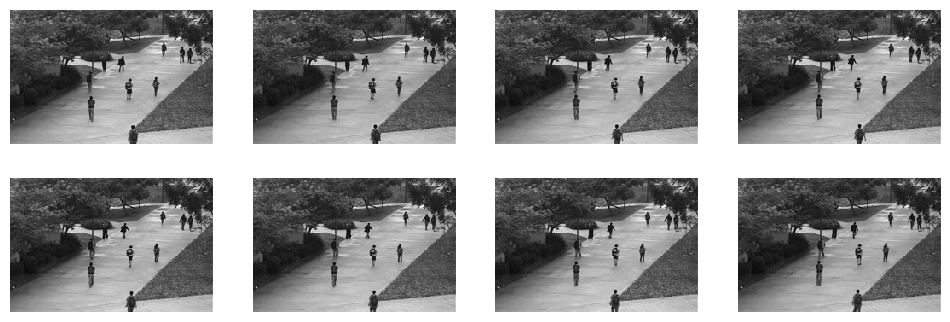

In [6]:
# You can change the following train_sample_folder to another folder to view other clips
train_sample_folder = 'Train034'
image_range = (1,9)  # this display image from 1 to 8
image_folder = os.path.join(train_dir, train_sample_folder)
display_images(image_folder, image_range=image_range, max_per_row=4)

#### Visualize as 'Video'

We will convert the image frames to a 'video' (actually as animated gif) for easier viewing. The video consists of 200 frames. From the left navigation panel, you will see that a gif file called `<train_sample_folder_name>.gif` has been created, e.g. `Train034.gif`.

In [7]:
gif_filename = train_sample_folder + '.gif'
create_gif(image_folder, gif_filename, img_type='tif')

Now we will play the video.

In [8]:
with open(gif_filename,'rb') as file:
    display(ipyImage(file.read(), format='png'))

Output hidden; open in https://colab.research.google.com to view.

## Visualize the Test dataset

Let us visualize the video frames from the test dataset folder Test001, as an animated gif. You should be able to see some anomalous event (e.g. someone riding a bicycle) in the animated gif you create.

In [9]:
# set the test sample folder to folder of Test001 and set the image_folder accordingly
test_sample_folder = 'Test001'
image_folder = os.path.join(test_dir, test_sample_folder)

gif_filename = test_sample_folder + '.gif'
create_gif(image_folder, gif_filename, img_type='tif')

with open(gif_filename,'rb') as file:
    display(ipyImage(file.read(), format='png'))

Output hidden; open in https://colab.research.google.com to view.

### Prepare Training and Validation Dataset

Now we create a Tensorflow dataset suitable for use in training the Autoencoder network later. In preparing the dataset, we resize all the images to same height `(IMG_HEIGHT)` and width `(IMG_WIDTH)`. Typically we set the height the same as width (square image) for training, even though the original image may not be square. For deep learning network, it does not matter whether the image is square or rectangle.

We also split the data into training set (80%) and validation set (20%). We use the validation set to check if we are overfitting model to the training data.

In [10]:
IMG_HEIGHT=100
IMG_WIDTH=100
BATCH_SIZE=32

train_fileset = os.path.join(train_dir, '*/*.tif')

train_dataset, validation_dataset = prepare_dataset(train_fileset,
                                img_height=IMG_HEIGHT,
                                img_width=IMG_WIDTH,
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                split=True,
                                test_size=0.2)

6800it [00:08, 799.20it/s]


In [11]:
# We have a total of 34 x 200 = 6800 images.
# 80% allocated to train set = (0.8 * 6800)/16 = 340 batches
# 20% allocated to validation set = (0.2 * 6800)/16 = 85

print('Number of batches of train images = {}'.format(len(list(train_dataset))))
print('Number of batches of validation images = {}'.format(len(list(validation_dataset))))

Number of batches of train images = 170
Number of batches of validation images = 43


### Building the Autoencoder Model


![autoencoder](https://nyp-aicourse.s3-ap-southeast-1.amazonaws.com/resources/autoencoder.png)


We will first build the Encoder network. In the lecture, we learnt that autoencoder learns the latent representation of the data by having a bottleneck layer, so that it is forced to capture only the most important features that allows it to reconstruct the input.
You can see that as we move deeper into the encoder, the number of neurons typically are getting smaller and is the smallest at the 'latent' layer.

In [12]:
# The encoder part of the Audo-encoder model
inputs = tf_keras.layers.Input(shape=(100,100,1))
x = tf_keras.layers.Conv2D(32, kernel_size=5, activation='relu')(inputs)
x = tf_keras.layers.MaxPool2D(pool_size=2)(x)
x = tf_keras.layers.Conv2D(32, kernel_size=5, activation='relu')(x)
x = tf_keras.layers.MaxPool2D(pool_size=2)(x)
x = tf_keras.layers.Flatten()(x)
encoded = tf_keras.layers.Dense(2000)(x)
encoder = tf_keras.Model(inputs=[inputs], outputs=[encoded])


Let's print out the model's summary so that we can see the number of output (think of these as number of neurons) at each layer. As you will observe, our input layer has input shape of 100x100x1 (Note: the last number is the number of channels, and since we dealing with grayscale image, there is only 1 channel).

After the 1st convolutional + maxpooling layer, the number of outputs becomes 48x48x32. This is further reduced after the 2nd convolutional + maxpooling layer, to 22x22x32, and further reduced to 2000  at the latent layer. This means the network is forced to learn to capture the most important 'latent' information in the training data into a mere 2000 neurons. The information captured in this latent layer will then be used by the decoder to reconstruct the original image.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 15488)             0     

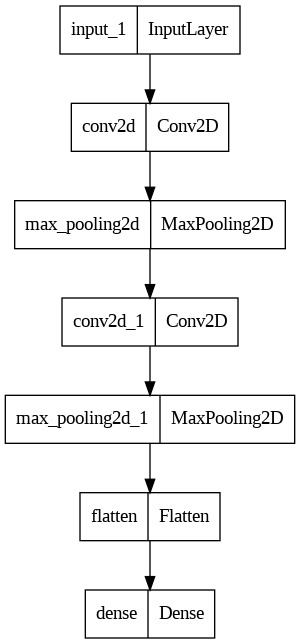

In [13]:
encoder.summary()
tf_keras.utils.plot_model(encoder)

Now we will build the decoder part of the network.

In [14]:
# The decoder part of the Audo-encoder model

decoder_inputs = tf_keras.layers.Input(shape=(2000))
x = tf_keras.layers.Dense(22*22*32, activation='relu')(decoder_inputs)
x = tf_keras.layers.Reshape(target_shape=(22,22,32))(x)
x = tf_keras.layers.UpSampling2D(2, interpolation='nearest')(x)
x = tf_keras.layers.Conv2DTranspose(32, kernel_size=5, activation='relu')(x)
x = tf_keras.layers.UpSampling2D(2, interpolation='nearest')(x)
decoded = tf_keras.layers.Conv2DTranspose(1, kernel_size=5, activation='sigmoid')(x)
decoder = tf_keras.Model(inputs=[decoder_inputs], outputs=[decoded])

Similarly we print out the summary of the decoder part, so that we can see the output shape of each decoder layer.
Opposite to the encoder, the number of neurons increases as we progress towards the output layer. We use Up-Sampling and Transpose Convolution to increase the number of neurons from 2000 units in the latent layer, to the original size of the input image, i.e. 100x100x1.

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense_1 (Dense)             (None, 15488)             30991488  
                                                                 
 reshape (Reshape)           (None, 22, 22, 32)        0         
                                                                 
 up_sampling2d (UpSampling2  (None, 44, 44, 32)        0         
 D)                                                              
                                                                 
 conv2d_transpose (Conv2DTr  (None, 48, 48, 32)        25632     
 anspose)                                                        
                                                                 
 up_sampling2d_1 (UpSamplin  (None, 96, 96, 32)        0   

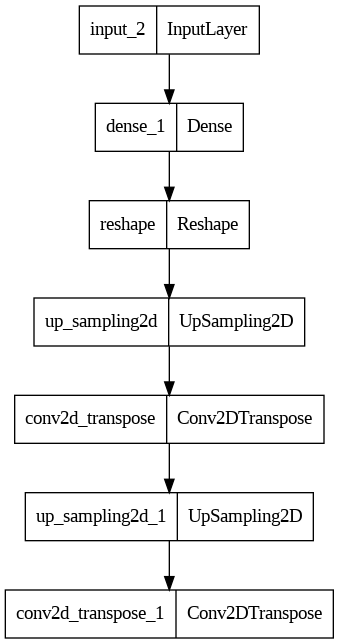

In [15]:
decoder.summary()
tf_keras.utils.plot_model(decoder)

Now we stack the encoder and decoder to become the complete autoencoder network.

In [16]:
encoding = encoder(inputs)
decoding = decoder(encoding)
conv_ae = tf_keras.Model(inputs=[inputs], outputs=[decoding])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 model (Functional)          (None, 2000)              31004464  
                                                                 
 model_1 (Functional)        (None, 100, 100, 1)       31017921  
                                                                 
Total params: 62022385 (236.60 MB)
Trainable params: 62022385 (236.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


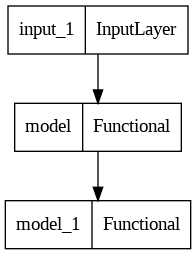

In [17]:
conv_ae.summary()
tf_keras.utils.plot_model(conv_ae)

In the code below, we specify to use Mean Squared Error (MSE) as our loss function. Basically the network compute the square of difference between original image and reconstructed image and use this loss (or MSE) to adjust the weights to minimise the loss. The MSE is given by the equation below:

$$\frac{1}{m}\sum_{i=1}^m (\hat{y}_{i} - y_i)^2$$


where $\hat{y}$ is the predicted output and $y$ is the actual value.



In [18]:
conv_ae.compile(loss=tf_keras.losses.MeanSquaredError(),
        optimizer=tf_keras.optimizers.Adam(lr=1e-4, weight_decay=1e-4),
        metrics=['mse'])


Let's the training begin!! This might take a while so *sit back, relax and wait!*

In [19]:
num_epochs = 30

history = conv_ae.fit(train_dataset,
                  validation_data=validation_dataset,
                  epochs=num_epochs)


Epoch 1/30
170/170 [==============================] - 12s 39ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 2/30
170/170 [==============================] - 6s 34ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 3/30
170/170 [==============================] - 6s 35ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 4/30
170/170 [==============================] - 7s 40ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 5/30
170/170 [==============================] - 6s 35ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 6/30
170/170 [==============================] - 6s 35ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 7/30
170/170 [==============================] - 6s 36ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 8/30
170/170 [==============================] - 6s 36ms/step -

Let's plot the training and validation loss to see how our network progress with the training.

In [20]:
## Uncomment below if GPU is not available for training
#!axel --quiet https://nyp-aicourse.s3.ap-southeast-1.amazonaws.com/aiup/day1-pm/train_history.pkl
#!axel --quiet https://nyp-aicourse.s3.ap-southeast-1.amazonaws.com/aiup/day1-pm/video_anomaly.model.zip
#!unzip video_anomaly.model.zip

#import pickle
#history = pickle.load(open("train_history.pkl", "rb"))
#conv_ae = tf_keras.models.load_model("video_anomaly.model")

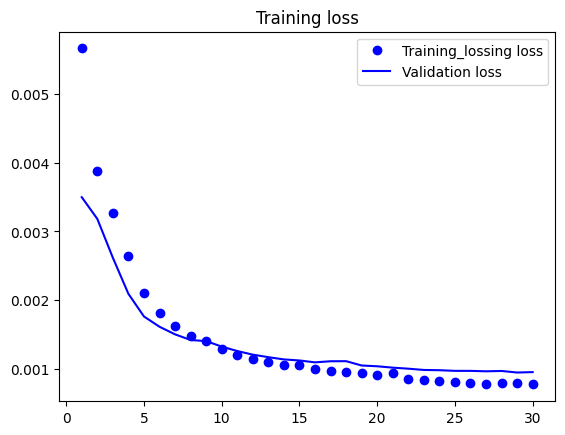

In [21]:
plot_training_loss(history.history)

Here we are just setting up path to a sample image from train set and test set respectively. The train sample shows a 'normal' scene, while the test sample shows an 'anomalous' scene.

In [22]:
# normal image taken from train set
normal_image = os.path.join(train_dir, 'Train001/001.tif')

# anomalous image taken from test set
anomalous_image = os.path.join(test_dir, 'Test024/140.tif')

Now we will take a 'normal' image from the train set, and see how well the autoencoder reconstructs it. We will plot the original image on the left and the reconstructed image on the right.

Here you can see that it can mostly reconstruct the original image (the left)

1/1 [==============================] - 0s 196ms/step


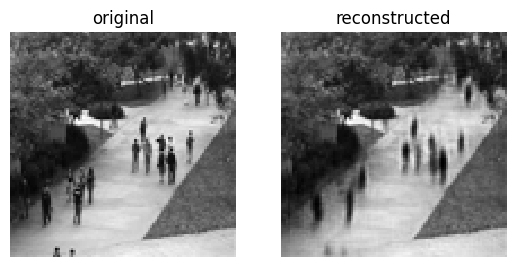

In [23]:
show_reconstructions(conv_ae, normal_image)

Let's look at the 'abnormal' image from the test set where a cart can be seen driving through the walkway.

Since the cart is something that the autoencoder has never seen before, it failed to reconstruct it properly.

1/1 [==============================] - 0s 20ms/step


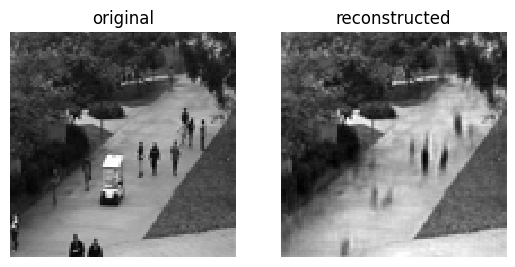

In [24]:
show_reconstructions(conv_ae, anomalous_image)

### Reconstruction Loss

Let's us look at how the reconstruction loss varies for each video frame of a test video, when we pass the video frames through the autoencoder.

In [25]:
BATCH_SIZE=1

test_sample_folder = 'Test014'

test_fileset = os.path.join(test_dir, test_sample_folder, "*.tif")

test_dataset = prepare_dataset(test_fileset,
                                img_height=IMG_HEIGHT,
                                img_width=IMG_WIDTH,
                                batch_size=BATCH_SIZE,
                                shuffle=False)
print(len(list(test_dataset)))

200it [00:00, 820.07it/s]


200


#### Reconstruction loss over different video frames

The following codes take all the video frames from the test folder and runs through the autoencoder and compute the reconstruction loss and show the reconstruction loss for each frame.

In [26]:
create_losses_animation(conv_ae, test_dataset, "losses.gif")
with open('losses.gif','rb') as file:
    display(ipyImage(file.read(), format='png'))

Output hidden; open in https://colab.research.google.com to view.

#### Identification of anomalous object from the video frames

In the codes above, our model can tell which frame is anomalous, but it does not tell us where is the anomaly in the frame.

Here we use the function `identify_anomaly()` to do that. The function compute the differences of each pixel between original frame and the reconstructed frame (for a total of 200 fames), and by comparing the differences over a patch of 4x4 pixels, and if the difference is above certain threshold, it will mark that patch with red color to signify that it is an anomalous region.

The 200 frames will be displayed as animated gif to better visualize the changes over time.



In [27]:
threshold = 4.0
identify_anomaly(conv_ae, test_dataset, "video.gif", threshold)
with open('video.gif','rb') as file:
    display(ipyImage(file.read(), format='png'))

Output hidden; open in https://colab.research.google.com to view.

**Exercise**

Try changing the threshold above to adjust the sensitivity of the certain pixels being classified as anomalous.